In [66]:
import numpy as np
import pandas as pd

import sklearn.neighbors as neighbors

from importlib import reload
import copy
import synthetic.render.generator as gen

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import images

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'
data = fio.read(catalog_path)
catalog_cluster = data[data['LOC'] == 1]
catalog_field = data[data['LOC'] == 0]

In [3]:
catalog = np.hstack((catalog_cluster, catalog_field))
catalog = np.hstack((catalog_cluster, catalog_field))
catalog['G1'] = 0.3
catalog['G2'] = -0.2

In [4]:
df = render.DrawField(5000, catalog, band="i")
df.prepare()
df.make_infodicts()
df.multi_render(100)
df.collate_stamps()

starting xshear calculations in 100 processes


In [5]:
noise_std = 8.36335 
noise = np.random.normal(scale=noise_std, size=(5000, 5000))

Text(0, 0.5, 'Y [pix]')

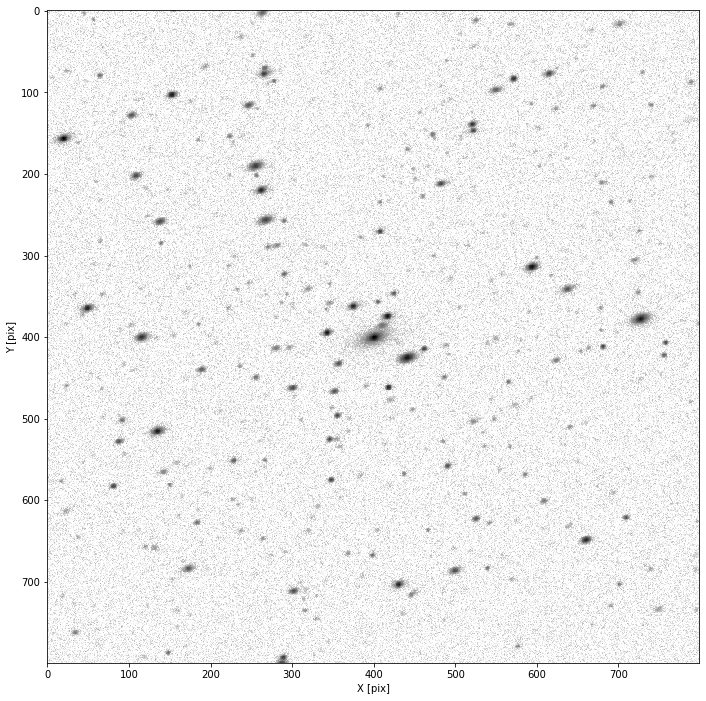

In [6]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
#cc = icl_arrs[2]
cc = df.canvas.array + noise
cc = cc[2100:2900, 2100:2900]
ax.imshow(images.asinh_scale(cc*0.01, 0.12) * 2, cmap=plt.cm.gray_r)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

In [7]:
arr = df.canvas.array + noise
#arr = arr[2100:2900, 2100:2900]
fio.write("test.fits", arr, clobber=True)

In [59]:
! sex test.fits -c  config.sex

> 
----- SExtractor 2.25.0 started on 2022-09-14 at 13:44:11 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for test.fits
----- Measuring from: test.fits
      "Unnamed" / no ext. header / 5000x5000 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at line:  832
> Setting up background map 

> Line: 1400  Objects:      983 detected /       60 sextracted
> Line: 1425  Objects:     1011 detected /       74 sextracted
> Line: 1450  Objects:     1039 detected /       92 sextracted
> Line: 1475  Objects:     1069 detected /      110 sextracted
> Line: 1500  Objects:     1098 detected /      130 sextracted
> Line: 1525  Objects:     1125 detected /      145 sextracted
> Line: 1550  Objects:     1158 detected /      163 sextracted
> Line: 1575  Objects:     1191 detected /      177 sextracted
> Line: 1600  Objects:     1221 detected /      192 sextracted
> Line: 1625  Objects:     1252 detected /      210 sextracted
> Line: 1650  Objects:     1290 detected /      223 sextracted
> Line: 1675  Objects:     1328 detected /      243 sextracted
> Line: 1700  Objects:     1364 detected /      260 sextracted
> Line: 1725  Objects:     1404 detected /      276 sextracted
> Line: 1750  Objects:     1436 detected /      305 sextracted
> Line: 1775  Objects:     1463 detected /      329 sex

> Line: 4350  Objects:     4878 detected /     3633 sextracted
> Line: 4375  Objects:     4898 detected /     3668 sextracted
> Line: 4400  Objects:     4915 detected /     3696 sextracted
> Line: 4425  Objects:     4932 detected /     3727 sextracted
> Line: 4450  Objects:     4950 detected /     3758 sextracted
> Line: 4475  Objects:     4979 detected /     3783 sextracted
> Line: 4500  Objects:     4996 detected /     3817 sextracted
> Line: 4525  Objects:     5015 detected /     3846 sextracted
> Line: 4550  Objects:     5040 detected /     3884 sextracted
> Line: 4575  Objects:     5053 detected /     3909 sextracted
> Line: 4600  Objects:     5068 detected /     3940 sextracted
> Line: 4625  Objects:     5078 detected /     3962 sextracted
> Line: 4650  Objects:     5089 detected /     3995 sextracted
> Line: 4654  Objects:     5090 detected /     4000 sextracted
> Line: 4675  Objects:     5105 detected /     4025 sextracted
> Line: 4700  Objects:     5117 detected /     4058 sex

In [60]:
cat = fio.read("test.cat.fits")
seg = fio.read("seg.fits")

In [61]:
ids = cat['NUMBER']
cens = np.vstack((cat['X_IMAGE'], cat['Y_IMAGE'])).T

In [62]:
cat["MAG_AUTO"]

array([22.062994, 20.59098 , 23.80166 , ..., 23.472692, 23.109953,
       22.951284], dtype=float32)

In [143]:
pos = np.vstack((df.xx, df.yy)).T

In [146]:
kdt = neighbors.KDTree(pos)

In [147]:
dist, ii = kdt.query(cens, return_distance=True)

In [165]:
catalog[ii]["MAG_I"][:, 0] - cat["MAG_AUTO"]


array([-0.10109077, -0.039977  , -0.02628007, ..., -0.24310483,
        0.04335072,  0.00142656])

array([0.80560031, 0.66295068, 0.55484842, ..., 0.43353778, 0.16743475,
       0.67802291])

In [181]:
dist[:, 0].max()

11.487766685882077

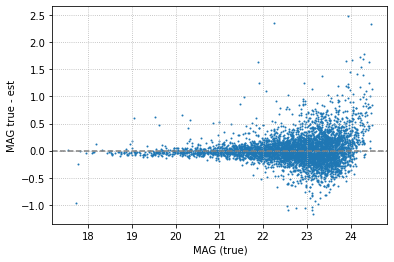

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111)

arr1 = catalog[ii]["MAG_I"][:, 0]
arr2 = catalog[ii]["MAG_I"][:, 0] - cat["MAG_AUTO"]
arr3 = dist[:, 0] / dist[:, 0].max()

ax.axhline(0, color="gray", ls="--")
ax.scatter(arr1, arr2, s=1)
ax.grid(ls=":")
ax.set_xlabel("MAG (true)")
ax.set_ylabel("MAG true - est")
fig.savefig("MAG_recovery.png", bbox_inches="tight")


In [113]:
catalog["X"][0, :] - cat["X_IMAGE"]

ValueError: operands could not be broadcast together with shapes (11281,) (4889,) 

In [16]:
class Shear(object):
    def __init__(self, canvas, image_epsf, maskmap):
        self.canvas = canvas.copy()
        self.image_epsf = image_epsf
        self.BADVAL = -9999
        self.maskmap = galsim.ImageI(maskmap).copy()
        
    def extract_stamps(self, centers, imasks, sizes):
                
        self.stamps = []
        self.masks = []
        for i in np.arange(len(centers)):
            half_size = sizes[i] // 2
            cen = centers[i]
            bb = galsim.bounds.BoundsI(np.round(cen[0]) - half_size,
                                       np.round(cen[0]) + half_size - 1,
                                       np.round(cen[1]) - half_size,
                                       np.round(cen[1]) + half_size - 1)
            stamp = self.canvas[bb].array.copy()
            mask = self.maskmap[bb].array.copy()
#             mm = (mask.array != imasks[i]) & (mask.array != 0)
            mm = (mask != imasks[i]) & (mask != 0)
            muniques = np.unique(mask)
#             print(np.unique(mask), imasks[i], bb)
            stamp[mm] = 0
            mask[mm] = 0
#             
            self.masks.append(self.maskmap[bb].array.copy())
            self.stamps.append(galsim.ImageF(stamp))


    def estimate_shear(self, sky_var=0, shear_est="KSB", which="canvas"):
        """
        shear modes = REGAUSS’, ‘LINEAR’, ‘BJ’, or ‘KSB’
        which is raw or canvas, default to canvas
        """
        
#         stamps = self.raw_stamps
        if which == "canvas":
            stamps = self.stamps
        
        self.logs = []
        self.shears = []
        self.success = []
        self.fluxes = []
        self.shears_error = []
        for i, im in enumerate(stamps):
            try:
                res = galsim.hsm.EstimateShear(im, self.image_epsf, shear_est=shear_est, sky_var=sky_var)
                self.logs.append(res)
                self.success.append(True)

                tmp = np.array([res.corrected_g1, res.corrected_g2])
                
                self.shears.append(tmp)
                self.fluxes.append(res.moments_amp * (0.27)**2)
                self.shears_error.append(res.corrected_shape_err)
#                 print("here")
            except:
                self.success.append(False)
                self.logs.append(None)
                self.fluxes.append(None)
                tmp = np.array([self.BADVAL, self.BADVAL])
                self.shears.append(tmp)
                self.shears_error.append(None)
                
                
               
        self.fluxes = np.array(self.fluxes)
        self.shears = np.array(self.shears)
        self.success = np.array(self.success)
        self.shears_error = np.array(self.shears_error)



In [190]:
sizes = np.around(cat["FWHM_IMAGE"] * 3)

In [191]:
sc = Shear(df.canvas, df.image_epsf, seg)
sc.extract_stamps(cens, imasks=ids, sizes=sizes)
sc.estimate_shear(sky_var=noise_std**2)

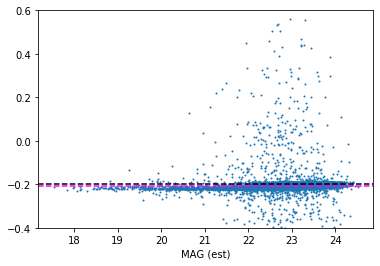

In [212]:
fig = plt.figure()
ax = fig.add_subplot(111)

arr1 = cat["MAG_AUTO"][sc.success]
arr2 = sc.shears[sc.success, 1]

# catalog['G2'] = -0.2
ax.axhline(-0.2, color="black", ls="--")
ax.axhline(arr2[arr1 < 22.5].mean(), ls="--", color="magenta")
ax.scatter(arr1, arr2, s=1)
ax.set_ylim(-0.4, 0.6)
# ax.grid(ls=":")
ax.set_xlabel("MAG (est)")
fig.savefig("MAG_G2.png", bbox_inches="tight")


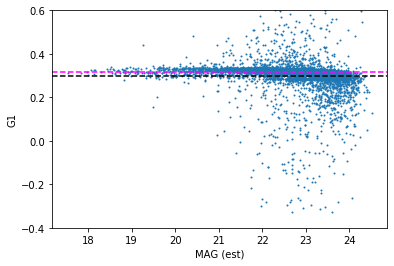

In [213]:
fig = plt.figure()
ax = fig.add_subplot(111)

arr1 = cat["MAG_AUTO"][sc.success]
arr2 = sc.shears[sc.success, 0]

# catalog['G2'] = -0.2
ax.axhline(0.3, color="black", ls="--")
ax.axhline(arr2[arr1 < 22.5].mean(), ls="--", color="magenta")
ax.scatter(arr1, arr2, s=1)
ax.set_ylim(-0.4, 0.6)
# ax.grid(ls=":")
ax.set_xlabel("MAG (est)")
ax.set_ylabel("G1")

fig.savefig("MAG_G1.png", bbox_inches="tight")


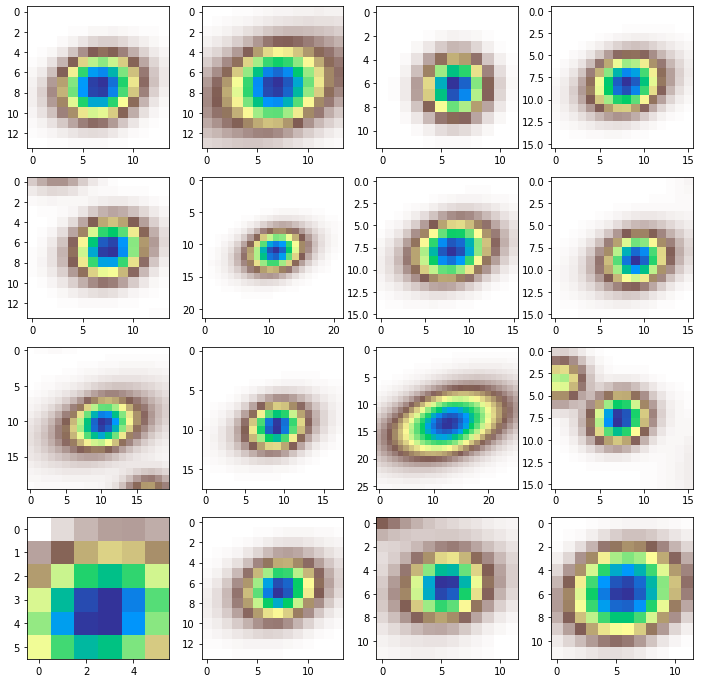

In [46]:
fig, axarr = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axarr.flatten()):
    cc = sc.stamps[i].array
    ax.imshow(images.asinh_scale(cc*0.01, 0.12) * 2, cmap=plt.cm.terrain_r,
              norm=mpl.colors.Normalize())
